# ResNet Matrix Factorization

In [8]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import (
    Add, 
    Input, 
    Embedding, 
    Dot, 
    Flatten, 
    Dense, 
    Concatenate,
    Dropout, 
    BatchNormalization,
    Activation
)
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [2]:
df = pd.read_csv('data/small_preprocessed_rating.csv')
print(df.shape)

(2206428, 6)


In [3]:
N = df.SmallUserId.max() + 1
M = df.SmallNewMovieId.max() + 1

In [4]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty

In [9]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)

# main branch
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

# side branch
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)

# merge
x = Add()([x, y])

model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    # optimizer='adam',
    # optimizer=Adam(lr=0.01),
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=['mse'],
)

r = model.fit(
    x=[df_train.SmallUserId.values, df_train.SmallNewMovieId.values],
    y=df_train.rating.values - mu,
    epochs=epochs,
    batch_size=128,
    validation_data=(
        [df_test.SmallUserId.values, df_test.SmallNewMovieId.values],
        df_test.rating.values - mu
    )
)

Epoch 1/15


/Users/allenchen/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-26 16:14:47.479714: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13791/13791 [==============================] - 14s 1ms/step - loss: 0.7223 - mse: 0.7223 - val_loss: 0.6733 - val_mse: 0.6733
Epoch 2/15
13791/13791 [==============================] - 14s 1ms/step - loss: 0.6652 - mse: 0.6652 - val_loss: 0.6556 - val_mse: 0.6556
Epoch 3/15
13791/13791 [==============================] - 14s 999us/step - loss: 0.6511 - mse: 0.6511 - val_loss: 0.6476 - val_mse: 0.6476
Epoch 4/15
13791/13791 [==============================] - 14s 1ms/step - loss: 0.6298 - mse: 0.6298 - val_loss: 0.6271 - val_mse: 0.6271
Epoch 5/15
13791/13791 [==============================] - 14s 1ms/step - loss: 0.5991 - mse: 0.5991 - val_loss: 0.6094 - val_mse: 0.6094
Epoch 6/15
13791/13791 [==============================] - 14s 1ms/step - loss: 0.5791 - mse: 0.5791 - val_loss: 0.6144 - val_mse: 0.6144
Epoch 7/15
13791/13791 [==============================] - 14s 1ms/step - loss: 0.5646 - mse: 0.5646 - val_loss: 0.5990 - val_mse: 0.5990
Epoch 8/15
13791/13791 [==========================

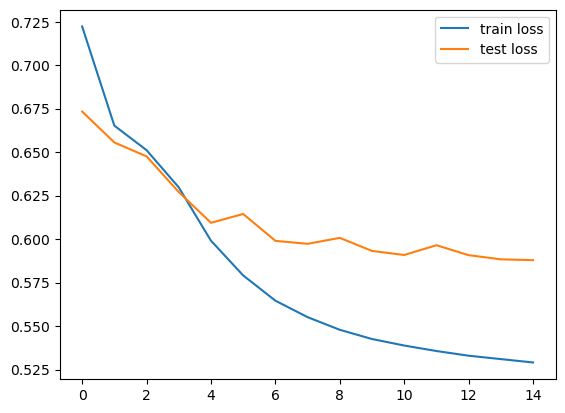

In [10]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()